In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Behavior

In [2]:
## Load data.
data = read_csv(os.path.join('data','data.csv'))

## Restrict participants.
reject = read_csv(os.path.join('data','reject.csv'))
data = data[data.Subject.isin(reject.query('Reject==0').Subject)].reset_index(drop=True)

#### 1.1 Accuracy

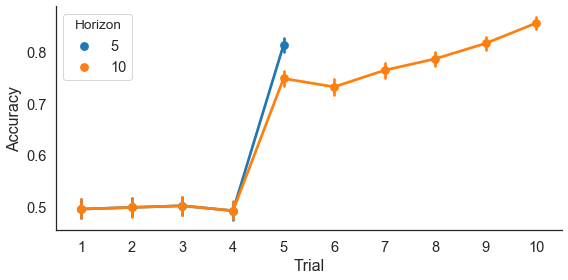

In [3]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot accuracy.
sns.pointplot('Trial', 'Accuracy', 'Horizon', data=data, ax=ax)

sns.despine()
plt.tight_layout()

#### 1.2 Choice Behavior by Reward 

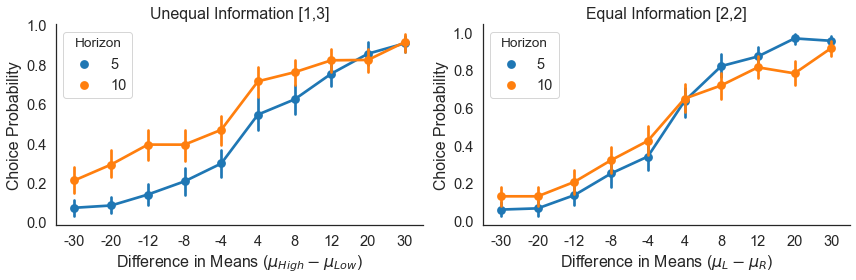

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot [3,1] games.
data['delta_31'] = np.where(data.Info==1, -data.delta, data.delta)
data['choice_31'] = np.where(data.Info==1, 1-data.Choice, data.Choice)
sns.pointplot('delta_31', 'choice_31', 'Horizon', data=data.query('Trial==5 and Info!=0'), ax=axes[0])
axes[0].set(xlabel=r'Difference in Means ($\mu_{High} - \mu_{Low}$)', ylabel='Choice Probability',
            title='Unequal Information [1,3]')

## Plot [2,2] games.
sns.pointplot('delta', 'Choice', 'Horizon', data=data.query('Trial==5 and Info==0'), ax=axes[1])
axes[1].set(xlabel=r'Difference in Means ($\mu_L - \mu_R$)', ylabel='Choice Probability',
            title='Equal Information [2,2]')

sns.despine()
plt.tight_layout()

#### 1.3 Accuracy by Horizon

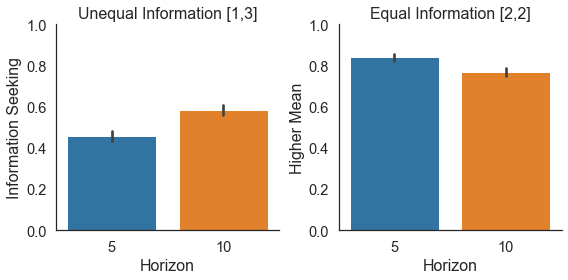

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Plot [3,1] games.
data['Seek'] = np.where(data.Info==-1, data.Choice, 1-data.Choice)
sns.barplot('Horizon', 'Seek', data=data.query('Trial==5 and Info!=0'), ax=axes[0])
axes[0].set(ylim=(0,1), ylabel='Information Seeking', title='Unequal Information [1,3]')

## Plot [2,2] games.
sns.barplot('Horizon', 'Accuracy', data=data.query('Trial==5 and Info==0'), ax=axes[1])
axes[1].set(ylim=(0,1), ylabel='Higher Mean', title='Equal Information [2,2]')

sns.despine()
plt.tight_layout()

#### 1.4 Individual Differences

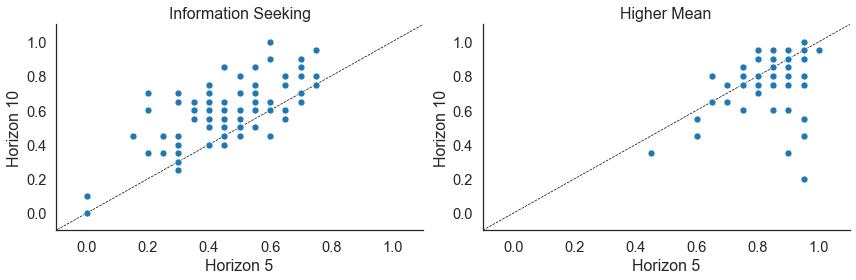

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Compute value of information within individuals.
gb = data.query('Trial==5 and Info!=0').groupby(['Subject','Horizon']).Seek.mean().reset_index()
gb = gb.pivot_table('Seek','Subject','Horizon')

## Plot [3,1] games.
sns.scatterplot(5, 10, data=gb, s=50, ax=axes[0])
axes[0].plot([-1,2], [-1,2], color='k', linestyle='--', lw=0.7, zorder=-1)
axes[0].set(xlim=(-0.1,1.1), xlabel='Horizon 5', ylim=(-0.1,1.1), ylabel='Horizon 10',
            title='Information Seeking')

## Compute decision noise within individuals.
gb = data.query('Trial==5 and Info==0').groupby(['Subject','Horizon']).Accuracy.mean().reset_index()
gb = gb.pivot_table('Accuracy','Subject','Horizon')

## Plot [2,2] games.
sns.scatterplot(5, 10, data=gb, s=50, ax=axes[1])
axes[1].plot([-1,2], [-1,2], color='k', linestyle='--', lw=0.7, zorder=-1)
axes[1].set(xlim=(-0.1,1.1), xlabel='Horizon 5', ylim=(-0.1,1.1), ylabel='Horizon 10',
            title='Higher Mean')

sns.despine()
plt.tight_layout()

## Section 2: Surveys

In [7]:
## Load survey data.
survey = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
reject = read_csv(os.path.join('data','reject.csv'))
survey = survey[survey.Subject.isin(reject.query('Reject==0').Subject)].reset_index(drop=True)

## Restrict to valid items.
columns = ['Subject'] + survey.filter(regex='pswq-q').columns[:-1].tolist() +\
          survey.filter(regex='ius12-q').columns[:-1].tolist() +\
          survey.filter(regex='nfc-q').columns[:-1].tolist()
          
items = survey[columns].copy()

#### 2.1 Sum Scores

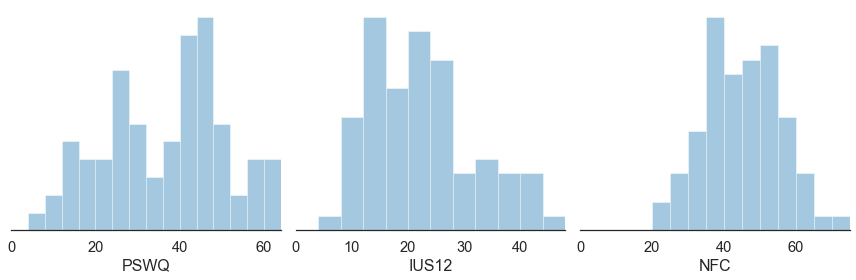

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Compute sum scores.
items['pswq'] = items.filter(regex='pswq-').sum(axis=1)
items['ius12'] = items.filter(regex='ius12-').sum(axis=1)
items['nfc'] = items.filter(regex='nfc-').sum(axis=1)

## Plot sum scores.
for ax, prefix in zip(axes, ['pswq','ius12','nfc']):
    
    ## Compute range.
    n_items = items.filter(regex=f'{prefix}-').shape[-1]
    anchor = items.filter(regex=f'{prefix}-').values.max()
    bins = np.arange(0, n_items*anchor+1, anchor)
    
    ## Plot scores.
    sns.distplot(items[prefix], kde=False, bins=bins, ax=ax)
    ax.set(xlim=(0,bins.max()), xlabel=prefix.upper(), yticks=[])
    
sns.despine(left=True)
plt.tight_layout()

#### 2.2 Item Correlation Matrix

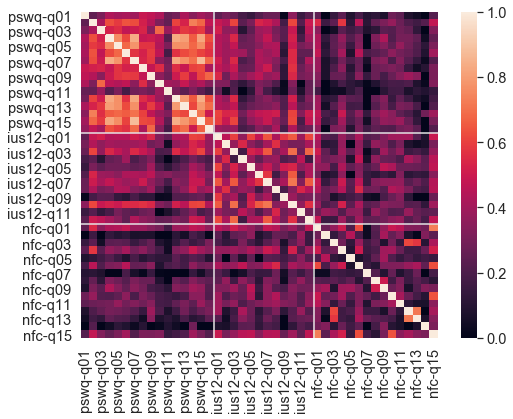

In [9]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))

## Plot.
sns.heatmap(items.filter(regex='-').corr(method='spearman'), vmin=0, vmax=1)
ax.vlines([16,28], 0, items.shape[1], color='0.9')
ax.hlines([16,28], 0, items.shape[1], color='0.9')

## Section 3: Correlations

In [ ]:
## Compute value of information within individuals.
gb = data.query('Trial==5 and Info!=0').groupby(['Subject','Horizon']).Seek.mean().reset_index()
gb = gb.pivot_table('Seek','Subject','Horizon')
gb['ratio'] = gb[10] / gb[5]
gb['delta'] = gb[10] - gb[5]

gb = gb.merge(items[['Subject'] + items.filter(regex='pswq').columns.tolist()], on='Subject')
sns.heatmap(gb.corr(method='spearman'), center=0, vmin=-1, vmax=1)

In [ ]:

## Compute decision noise within individuals.
gb = data.query('Trial==5 and Info==0').groupby(['Subject','Horizon']).Accuracy.mean().reset_index()
gb = gb.pivot_table('Accuracy','Subject','Horizon')
gb['ratio'] = gb[10] / gb[5]
gb['delta'] = gb[10] - gb[5]

gb = gb.merge(items[['Subject'] + items.filter(regex='pswq').columns.tolist()], on='Subject')
sns.heatmap(gb.corr(method='spearman'), center=0, vmin=-1, vmax=1)